# GPR Simulations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
import numpy as np
import healvis as hv
from healvis.data import DATA_PATH
import os
import copy
import healpy as healpy
import hera_pspec as hp
import h5py
from pyuvdata import UVData, UVBeam
from memory_profiler import memory_usage
import glob
from scipy import signal, stats, special
from sklearn import gaussian_process as gp
import hera_sim as hs
import uvtools as uvt
import hera_cal as hc
import emcee
from pyhmc import hmc
from scipy import optimize
import corner
import gp_utils

/Users/nkern/Software/anaconda3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/Users/nkern/Software/anaconda3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/Users/nkern/Software/anaconda3/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the

In [165]:
# load data
bls = [(0, 1)]
uvd_fg = UVData()
uvd_fg.read('../data/gsm_sim.uvh5', bls=bls)
uvd_eor = UVData()
uvd_eor.read("../data/eor_sim.uvh5", bls=bls)
uvd_n = UVData()
uvd_n.read("../data/noise_sim.uvh5", bls=bls)

antenna_diameters is not set. Using known values for HERA.


In [166]:
# select out times
uvd_full.select(times=np.unique(uvd_full.time_array)[:1])
uvd_fg.select(times=np.unique(uvd_fg.time_array)[:1])
uvd_eor.select(times=np.unique(uvd_eor.time_array)[:1])
uvd_n.select(times=np.unique(uvd_n.time_array)[:1])

In [182]:
G = gp.GaussianProcessRegressor(kernel=params[Keor_ind])
s = G.sample_y(freqs)
uvd_eor.data_array[:] = 0
uvd_eor.data_array += s * 100

In [184]:
# combine objects
uvd_n.data_array /= 3000
#uvd_n.data_array *= (uvd_n.freq_array[None, :, :, None]/160e6)**-10 / 10

uvd_full = copy.deepcopy(uvd_fg)
uvd_full.data_array += uvd_eor.data_array + uvd_n.data_array
#uvd_full.data_array += uvd_n.data_array

In [185]:
# setup data
D = hc.frf.FRFilter(uvd_full)
E = hc.frf.FRFilter(uvd_eor)
N = hc.frf.FRFilter(uvd_n)
F = hc.frf.FRFilter(uvd_fg)

Mean of empty slice.
invalid value encountered in double_scalars


In [186]:
# setup parameters for fitting
freqs = D.freqs[:, None] / 1e6

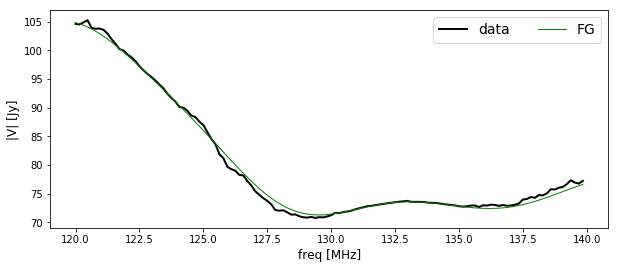

In [187]:
fig, ax = plt.subplots(figsize=(10, 4))
k = (0, 1, 'xx')
ax.plot(D.freqs/1e6, np.abs(D.data[k])[0], label='data', c='k', lw=2)
ax.plot(F.freqs/1e6, np.abs(F.data[k])[0], label='FG', c='green', lw=1)
ax.set_xlabel('freq [MHz]', fontsize=12)
ax.set_ylabel('|V| [Jy]', fontsize=12)
ax.legend(ncol=2, fontsize=14)

In [188]:
# define kernels
Ksky = gp.kernels.ConstantKernel(1, constant_value_bounds=(1e-1, 100)) \
       * gp.kernels.RBF(length_scale=10.0, length_scale_bounds=(10, 50))

Kmix = gp.kernels.ConstantKernel(1, constant_value_bounds=(1e-2, 10)) \
       * gp.kernels.RBF(length_scale=5.0, length_scale_bounds=(5, 10))
#Kmix = gp.kernels.ConstantKernel(1, constant_value_bounds=(1, 100)) \
#       * gp.kernels.Matern(length_scale=1.0, nu=3./2, length_scale_bounds=(5, 10))

Kfg = Ksky + Kmix

Keor = gp.kernels.ConstantKernel(1e-4, constant_value_bounds=(1e-8, 1e-3)) \
       * gp.kernels.Matern(length_scale=1.0, nu=0.5, length_scale_bounds=(1e-5, 5))

Knoise = gp.kernels.WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 10))

Kpln = gp.kernels.Product(Knoise, gp_utils.DiagPowerLawKernel(beta=2.0, beta_bounds=(1.0, 2.5), anchorx=120))

In [189]:
# setup GP model
optimizer = None#'fmin_l_bfgs_b'
n_restarts = 50
norm_y = False
G = gp_utils.GaussianProcess(kernel=trained_kernel,#Knoise + Keor + Kfg, 
                             optimizer=optimizer, n_restarts_optimizer=n_restarts,
                             copy_X_train=False, normalize_y=norm_y)
Ksky_ind = 'k2__k1'
Kmix_ind = 'k2__k2'
Keor_ind = 'k1__k2'
labels = [r'$\sigma_{\rm n}$',
          r'$\sigma_{\rm 21}$',
          r'$\ell_{21}$',
          r'$\sigma_{\rm sky}$',
          r'$\ell_{\rm sky}$',
          r'$\sigma_{\rm mix}$',
          r'$\ell_{\rm mix}$']

In [190]:
# fit, condition and predict
D.sky = hc.datacontainer.DataContainer({})
D.mix = hc.datacontainer.DataContainer({})
E.mdl = hc.datacontainer.DataContainer({})
for k in D.data:
    # stack real and imag
    ydata = np.vstack([D.data[k].real, D.data[k].imag])
    
    # train on both real and imaginary using scipy (as separate features)
    G.fit(freqs, ydata.T)
    print(G.kernel_)
    trained_kernel = G.kernel_
    params = trained_kernel.get_params()
    params['k'] = trained_kernel

    # train w/ emcee
    #tk, chain = emcee_train()
    
    # get FG conditional distribution given trained kernel
    if Ksky_ind in params:
        ypred = G.predict(freqs, kernel=params[Ksky_ind]).T
        ypred = ypred[:1] + 1j * ypred[1:]
        D.sky[k] = ypred
    else:
        D.sky[k] = np.zeros_like(D.data[k])
   
    # get FG conditional distribution given trained kernel
    if Kmix_ind in params:
        ypred = G.predict(freqs, kernel=params[Kmix_ind]).T
        ypred = ypred[:1] + 1j * ypred[1:]
        D.mix[k] = ypred
    else:
        D.mix[k] = np.zeros_like(D.data[k])

    # get EoR conditional distribution given trained kernel
    if Keor_ind in params:
        ypred = G.predict(freqs, kernel=params[Keor_ind]).T
        ypred = ypred[:1] + 1j * ypred[1:]
        E.mdl[k] = ypred
    else:
        E.mdl[k] = np.zeros_like(D.data[k])
D.mdl = D.sky + D.mix

WhiteKernel(noise_level=0.27) + 0.0316**2 * Matern(length_scale=1.03, nu=0.5) + 10**2 * RBF(length_scale=10) + 3.16**2 * RBF(length_scale=5)


In [86]:
chain = gp_utils.emcee_train(G.kernel_.theta, G, nstep=200, nwalkers=30, a=1.5)
ndims = chain.shape[1]

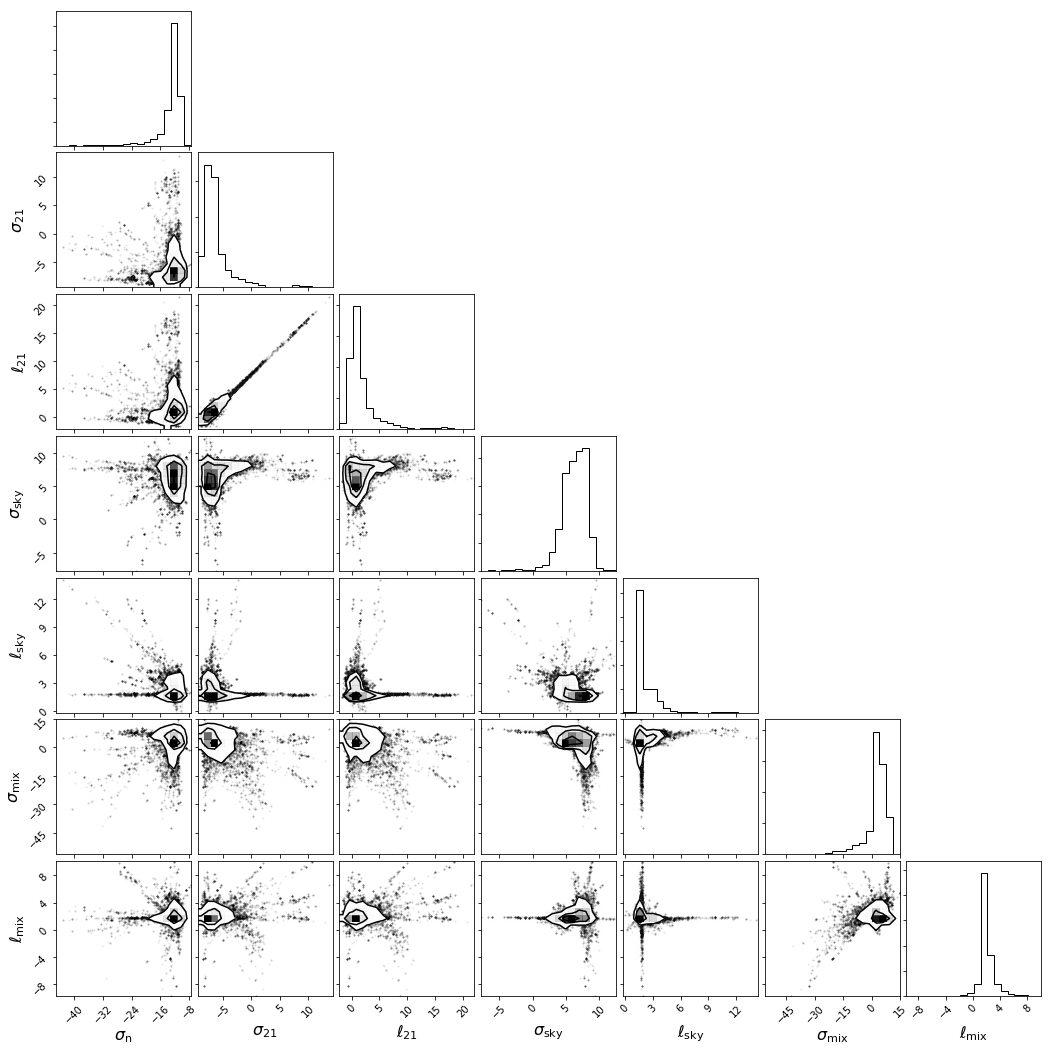

In [87]:
fig, axes = plt.subplots(ndims, ndims, figsize=(15, 15))

_ = corner.corner(chain, fig=fig)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        if j == 0 and i > 0:
            ax.set_ylabel(labels[i], fontsize=16)
        if i == axes.shape[0]-1:
            ax.set_xlabel(labels[j], fontsize=16)

In [191]:
# take difference with data
D.resid = D.data - D.mdl

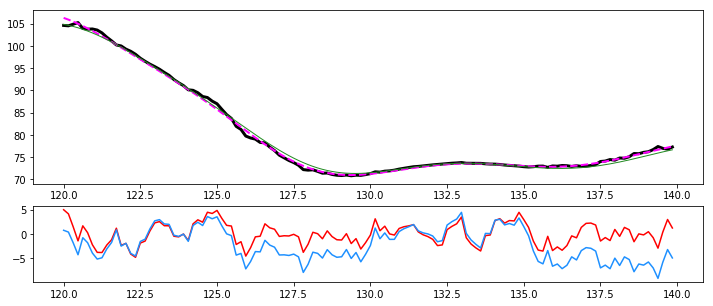

In [192]:
grid = gridspec.GridSpec(nrows=3, ncols=1)
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(hspace=0.3)
k = (0, 1, 'xx')

ax = fig.add_subplot(grid[:2, :])
ax.plot(D.freqs/1e6, np.abs(D.data[k]).T, lw=3, c='k')
ax.plot(D.freqs/1e6, np.abs(D.mdl[k]).T, ls='--', lw=2, c='magenta')
ax.plot(D.freqs/1e6, np.abs(F.data[k]).T, lw=1, c='forestgreen')

ax = fig.add_subplot(grid[2:, :])
ax.plot(D.freqs/1e6, np.real(D.resid[k]).T, c='r')
ax.plot(D.freqs/1e6, np.real(E.data[k]).T, c='dodgerblue')

In [193]:
# take fft
window = 'bh7'
D.fft_data(window=window, overwrite=True)
E.fft_data(window=window, overwrite=True)
F.fft_data(window=window, overwrite=True)
N.fft_data(window=window, overwrite=True)

E.fft_data(data=E.mdl, window=window, overwrite=True, assign='mfft')
D.fft_data(data=D.resid, window=window, overwrite=True, assign='rfft')
D.fft_data(data=D.mdl, window=window, overwrite=True, assign='mfft')

In [194]:
C = hp.conversions.Cosmo_Conversions()
t2k = C.tau_to_kpara(C.f2z(np.mean(D.freqs))) / 1e9

Text(0.5, 0, '$k_\\parallel$')

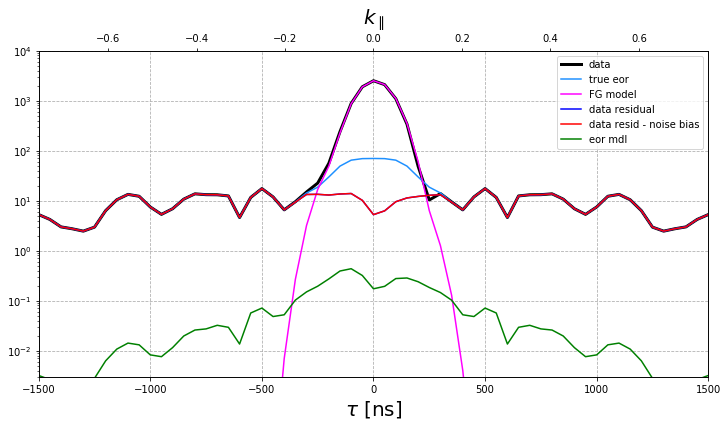

In [195]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(D.delays, np.abs(D.dfft[k])[0], c='k', lw=3, label='data')
ax.plot(D.delays, np.abs(E.dfft[k])[0], c='dodgerblue', lw=1.5, label='true eor')
ax.plot(D.delays, np.abs(D.mfft[k])[0], c='magenta', lw=1.5, label='FG model')
ax.plot(D.delays, np.abs(D.rfft[k])[0], c='b', lw=1.5, label='data residual')
ax.plot(D.delays, np.abs(D.rfft[k])[0] - np.abs(N.dfft[k])[0], c='r', lw=1.5, label='data resid - noise bias')
ax.plot(D.delays, np.abs(E.mfft[k])[0], c='g', lw=1.5, label='eor mdl')

ax.set_yscale('log')
ax.grid(ls='--')
ax.set_xlabel(r'$\tau$ [ns]', fontsize=20)
ax.legend(fontsize=10)
ax.set_xlim(-1500, 1500)
ax.set_ylim(3e-3, 1e4)

ax2 = plt.twiny(ax=ax)
ax2.set_xlim(ax.get_xlim()[0] * t2k, ax.get_xlim()[1] * t2k)
ax2.set_xlabel(r'$k_\parallel$', fontsize=20, labelpad=10)